# Explaining ANN (Classification) to identify depression

## Import all necessary libraries

Of the following imports, the most important libraries are: sklearn.neural_network and sklearn.metrics.

In [1]:
import joblib
import dice_ml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from alibi.explainers.ale import ALE, plot_ale

## Defining global variables

The following variables defined below can be modified according to the given approach.

In [2]:
## Global variable designated for data loading.
path_dataset = "Dataset_MO_ENG.csv"
path_dataset_qa = "Dataset_QA_ENG.csv"
path_dataset_qs = "Dataset_QS_ENG.csv"
path_dataset_qm = "Dataset_QM_ENG.csv"
path_dataset_qd = "Dataset_QD_ENG.csv"

## Global variables designated for threshold control.
positive_threshold = 0.01
negative_threshold = -0.01

## Global improvement variable of the neural network.
list_contr = [3, 4, 5, 14, 21, 24, 25, 26, 27, 29, 30, 32, 48, 49, 51, 54, 55, 58, 59, 60, 62, 63, 66, 68,
              70, 75, 78, 83, 85, 86, 87, 89, 90, 91, 94, 95, 96, 98, 100, 101]

## Anomadic question identification mode.
selection_mode = 2
regul_param_normal = 10.0 ** -np.arange(-2, 7)
regul_param_alpha = 10.0 ** -np.arange(0, 7)

## Defining private variables

The following variables defined below cannot be modified since they are an integral part of its operation.

In [3]:
## Private variables for the neural network by classification.
class_dic = { 1: 0 , 2: 0, 3:1, 4:2, 5:2}
target_names = ["Low", "Medium", "High"]

## Private variables for oversample.
random_state = 13
oversample = SMOTE(random_state=random_state)

## Private variables for neural network generation.
seed = 1

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [4]:
## Loading data from the dataset.
df = pd.read_csv(path_dataset)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

1. Most of the time I have difficulty concentrating on simple tasks  \
0                                                    1                     
1                                                    1                     
2                                                    0                     
3                                                    0                     
4                                                    1                     
..                                                 ...                     
99                                                   1                     
100                                                  1                     
101                                                  0                     
102                                                  1                     
103                                                  1                     

     2. I don't feel like doing my daily duties  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             1   
..                                          ...   
99                                            1   
100                                           1   
101                                           0   
102                                           0   
103                                           1   

     3. My friends or family have told me that I look different  \
0                                                    0            
1                                                    1            
2                                                    0            
3                                                    0            
4                                                    0            
..                                                 ...            
99                                                   1            
100                                                  0            
101                                                  1            
102                                                  0            
103                                                  0            

     4. When I think about the future it is difficult for me to imagine it clearly  \
0                                                    1                               
1                                                    1                               
2                                                    0                               
3                                                    1                               
4                                                    1                               
..                                                 ...                               
99                                                   0                               
100                                                  0                               
101                                                  1                               
102                                                  0                               
103                                                  0                               

     5. People around me often ask me how I feel  \
0                                              0   
1                                              0   
2                                              1   
3                                              0   
4                                              0   
..                                           ...   
99                                             0   
100                                            1   
101                                            1   
102                                            1   
103                                            0   

     6. I consid

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [5]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [6]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [7]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [9]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.16659498207885304,
  0.16659498207885304,
  0.4763355552829237,
  0.4513935101705999,
  0.46248242125951106,
  0.4691799342728135,
  0.4691799342728135,
  0.4691799342728135,
  0.4691799342728135],
 [0.006020651927912844,
  0.006020651927912844,
  0.09918844066715299,
  0.08068804784278276,
  0.09270871998125078,
  0.08309589200633044,
  0.08309589200633044,
  0.08309589200633044,
  0.08309589200633044])

We proceed to draw the learning curve graph according to the data obtained by the training.

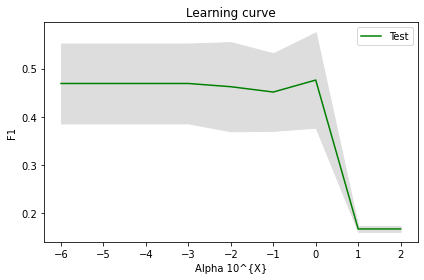

In [10]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [11]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.16659498207885304,
  0.46703181808444966,
  0.45220030972352954,
  0.4405739461776614,
  0.4763355552829237,
  0.16659498207885304,
  0.16659498207885304],
 [0.006020651927912844,
  0.0700006268704352,
  0.09521251410308869,
  0.0887293445552907,
  0.09918844066715299,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

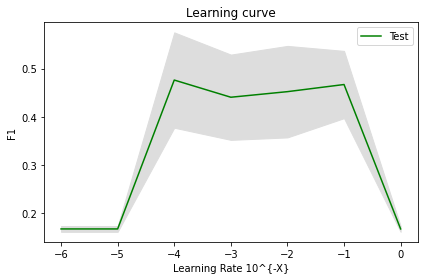

In [12]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [13]:
## The value of the alpha parameter is kept at 1 as well as the value of the seed of random_state at 77.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = 77)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=1, hidden_layer_sizes=(10,),
              learning_rate_init=0.0001, max_iter=100000, random_state=77)

We safeguard the final generated model

In [14]:
joblib.dump(mlp,"model_depression.pkl")

['model_depression.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

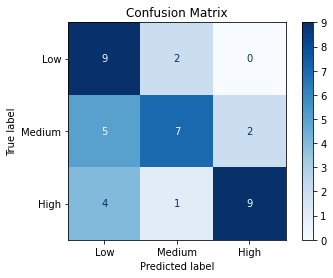

In [15]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [16]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 64.1025641025641 %

              precision    recall  f1-score   support

           0       0.50      0.82      0.62        11
           1       0.70      0.50      0.58        14
           2       0.82      0.64      0.72        14

    accuracy                           0.64        39
   macro avg       0.67      0.65      0.64        39
weighted avg       0.69      0.64      0.64        39



## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [17]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

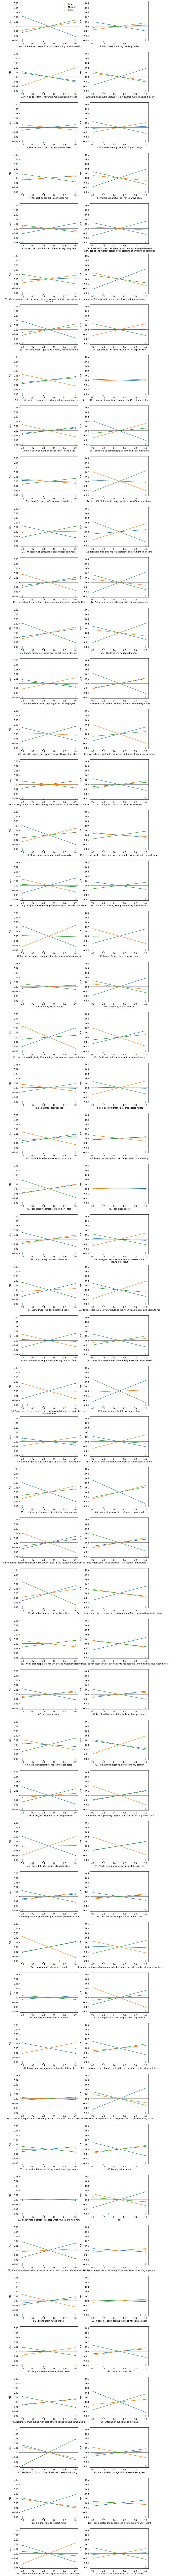

In [18]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 180});

## Neural network model improvement iterative process

From this moment, we proceed to improve the performance of the neural network to predict high depression.

## Iteration 1

The first iteration of improvement of the model is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [19]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of list of conflicting questions declared in global variables.
i = 0
for x in list_contr:
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1
    
    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

1. Most of the time I have difficulty concentrating on simple tasks  \
0                                                    1                     
1                                                    1                     
2                                                    0                     
3                                                    0                     
4                                                    1                     
..                                                 ...                     
99                                                   1                     
100                                                  1                     
101                                                  0                     
102                                                  1                     
103                                                  1                     

     2. I don't feel like doing my daily duties  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             1   
..                                          ...   
99                                            1   
100                                           1   
101                                           0   
102                                           0   
103                                           1   

     6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     7. My hobbies are still important to me  \
0                                          1   
1                                          1   
2                                          1   
3                                          1   
4                                          0   
..                                       ...   
99                                         1   
100                                        1   
101                                        1   
102                                        1   
103                                        1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     9. If I had the chance, I would spend all day in my bed  \
0                                                    0         
1                                                    0         
2                                                    0         
3                                                    1         
4                                                    1         
..                                                 ...         
99                                                   0         
100                             

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [20]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [21]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [22]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [24]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.16659498207885304,
  0.19322610764736,
  0.33584807349513235,
  0.4624614446441072,
  0.4712849740558719,
  0.48138800942206517,
  0.48138800942206517,
  0.48138800942206517,
  0.48138800942206517],
 [0.006020651927912844,
  0.06190163786344686,
  0.04574358771581292,
  0.08331624906294144,
  0.07035317262431248,
  0.086614802288128,
  0.086614802288128,
  0.086614802288128,
  0.086614802288128])

We proceed to draw the learning curve graph according to the data obtained by the training.

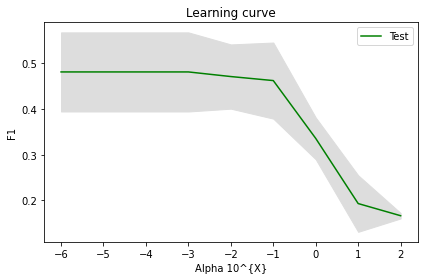

In [25]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [26]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.1632974910394265,
  0.4740513614352624,
  0.4483093256932267,
  0.4577127585177121,
  0.33584807349513235,
  0.16659498207885304,
  0.16659498207885304],
 [0.006619092595549127,
  0.14126534835534385,
  0.1542276089835744,
  0.11392529450516314,
  0.04574358771581292,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

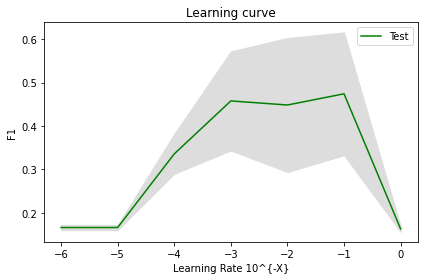

In [27]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [28]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [29]:
joblib.dump(mlp,"model_depression_i1.pkl")

['model_depression_i1.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

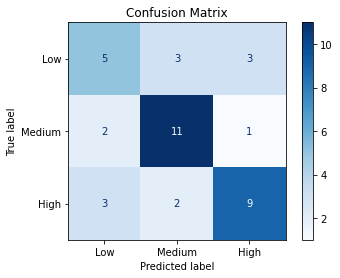

In [30]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [31]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 64.1025641025641 %

              precision    recall  f1-score   support

           0       0.50      0.45      0.48        11
           1       0.69      0.79      0.73        14
           2       0.69      0.64      0.67        14

    accuracy                           0.64        39
   macro avg       0.63      0.63      0.63        39
weighted avg       0.64      0.64      0.64        39



In [32]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## The number of questions used in the iteration is retrieved.
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  3,4,5,14,21,24,25,26,27,29,30,32,48,49,51,54,5...        64.102564   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0          0.5  0.454545     0.47619         11       0.6875  0.785714   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0    0.733333         14     0.692308  0.642857    0.666667         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [33]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

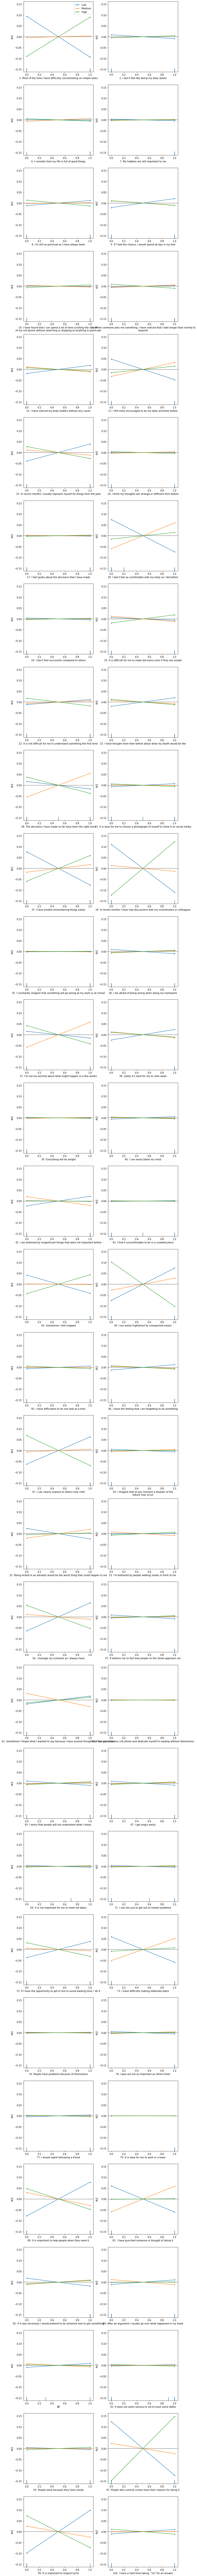

In [34]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 150});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [35]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0         1  -0.188073    0.180665            NA             NA          NA   
1         2  -0.017648    0.009065            NA             NA          NA   
2         6  -0.001497   -0.011459            NA             NA          NA   
3         7  -0.007423    0.002598            NA             NA          NA   
4         8   0.023104   -0.026986            NA             NA          NA   
..      ...        ...         ...           ...            ...         ...   
57       92   0.006494   -0.007989            NA             NA          NA   
58       93  -0.008606    0.011228            NA             NA          NA   
59       97  -0.247825    0.294782            NA             NA          NA   
60       99   0.196822   -0.146336            NA             NA          NA   
61      102   0.020829   -0.022950            NA             NA          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
..          ...  
57           NA  
58           NA  
59           NA  
60           NA  
61           NA  

[62 rows x 7 columns]

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [36]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0         1  -0.188073    0.180665             0              1          NA   
1         2  -0.017648    0.009065             0             NA          NA   
2         6  -0.001497   -0.011459            NA              0          NA   
3         7  -0.007423    0.002598            NA             NA          NA   
4         8   0.023104   -0.026986             1              0          NA   
..      ...        ...         ...           ...            ...         ...   
57       92   0.006494   -0.007989            NA             NA          NA   
58       93  -0.008606    0.011228            NA              1          NA   
59       97  -0.247825    0.294782             0              1          NA   
60       99   0.196822   -0.146336             1              0          NA   
61      102   0.020829   -0.022950             1              0          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
..          ...  
57           NA  
58           NA  
59           NA  
60           NA  
61           NA  

[62 rows x 7 columns]

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [37]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        1  La mayor parte del tiempo tengo dificultad par...   1
1        2    No siento ganas de hacer mis deberes cotidianos   1
2        6   Considero que mi vida está llena de cosas buenas   0
3        7             Mis aficiones siguen siendo importante   0
4        8       Sigo siendo tan puntual como siempre he sido   0
..     ...                                                ...  ..
57      92            No me parece grave tener algunas deudas   1
58      93             La gente roba porque tiene necesidades   1
59      97  La gente que comete crímenes tiene sus razones...   1
60      99                  Es importante respetar los turnos   0
61     102   Me cuesta trabajo aceptar un “no” como respuesta   1

[62 rows x 3 columns]

We proceed to identify the anomadic questions present in the model present in this iteration.

In [38]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0         1  -0.188073    0.180665             0              1           0   
1         2  -0.017648    0.009065             0             NA           0   
2         6  -0.001497   -0.011459            NA              0          NA   
3         7  -0.007423    0.002598            NA             NA          NA   
4         8   0.023104   -0.026986             1              0           0   
..      ...        ...         ...           ...            ...         ...   
57       92   0.006494   -0.007989            NA             NA          NA   
58       93  -0.008606    0.011228            NA              1          NA   
59       97  -0.247825    0.294782             0              1           0   
60       99   0.196822   -0.146336             1              0           0   
61      102   0.020829   -0.022950             1              0           1   

   Anomaly High  
0             0  
1            NA  
2             0  
3            NA  
4             0  
..          ...  
57           NA  
58            0  
59            0  
60            0  
61            1  

[62 rows x 7 columns]

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [39]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[9, 11, 12, 15, 23, 38, 44, 45, 46, 72, 102]

## Iteration 2

The second iteration of improvement of the model is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [40]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## The number of questions eliminated in the improvement process is retrieved..
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of the list of anomadic questions defined in the improvement process.
i = 0
for x in ds_delete['Question'].tolist():
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

1. Most of the time I have difficulty concentrating on simple tasks  \
0                                                    1                     
1                                                    1                     
2                                                    0                     
3                                                    0                     
4                                                    1                     
..                                                 ...                     
99                                                   1                     
100                                                  1                     
101                                                  0                     
102                                                  1                     
103                                                  1                     

     2. I don't feel like doing my daily duties  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             1   
..                                          ...   
99                                            1   
100                                           1   
101                                           0   
102                                           0   
103                                           1   

     6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     7. My hobbies are still important to me  \
0                                          1   
1                                          1   
2                                          1   
3                                          1   
4                                          0   
..                                       ...   
99                                         1   
100                                        1   
101                                        1   
102                                        1   
103                                        1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular  \
0                                                    0                                                                                                 
1                                                    0                                                                                                 
2                                                    1                                  

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [41]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [42]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [43]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [45]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.15999999999999998,
  0.24206284943127052,
  0.30571779236432206,
  0.28391696838958497,
  0.2849352225812138,
  0.2849352225812138,
  0.2849352225812138,
  0.2849352225812138,
  0.2849352225812138],
 [0.005443310539518168,
  0.05412997390137115,
  0.07837114850112376,
  0.0760679130846169,
  0.07647789235276374,
  0.07647789235276374,
  0.07647789235276374,
  0.07647789235276374,
  0.07647789235276374])

We proceed to draw the learning curve graph according to the data obtained by the training.

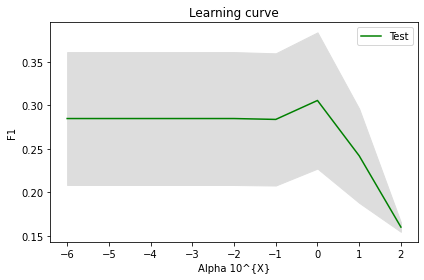

In [46]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [47]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.20002265570686623,
  0.4314402264402264,
  0.4498720090825354,
  0.4378194102652307,
  0.30571779236432206,
  0.16659498207885304,
  0.16659498207885304],
 [0.03854518308236841,
  0.13062146376380732,
  0.13455453846003146,
  0.1275674740375547,
  0.07837114850112376,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

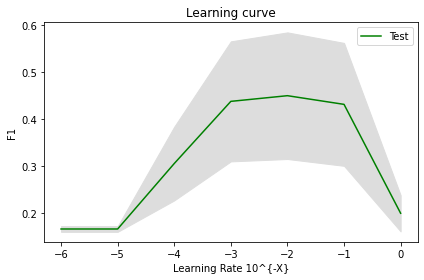

In [48]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [49]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [50]:
joblib.dump(mlp,"model_depression_i2.pkl")

['model_depression_i2.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

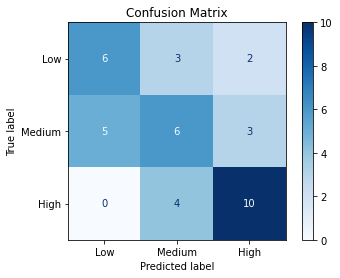

In [51]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [52]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 56.41025641025641 %

              precision    recall  f1-score   support

           0       0.55      0.55      0.55        11
           1       0.46      0.43      0.44        14
           2       0.67      0.71      0.69        14

    accuracy                           0.56        39
   macro avg       0.56      0.56      0.56        39
weighted avg       0.56      0.56      0.56        39



In [53]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  3,4,5,9,11,12,14,15,21,23,24,25,26,27,29,30,32...        56.410256   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0     0.545455  0.545455    0.545455         11     0.461538  0.428571   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0    0.444444         14     0.666667  0.714286    0.689655         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [54]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

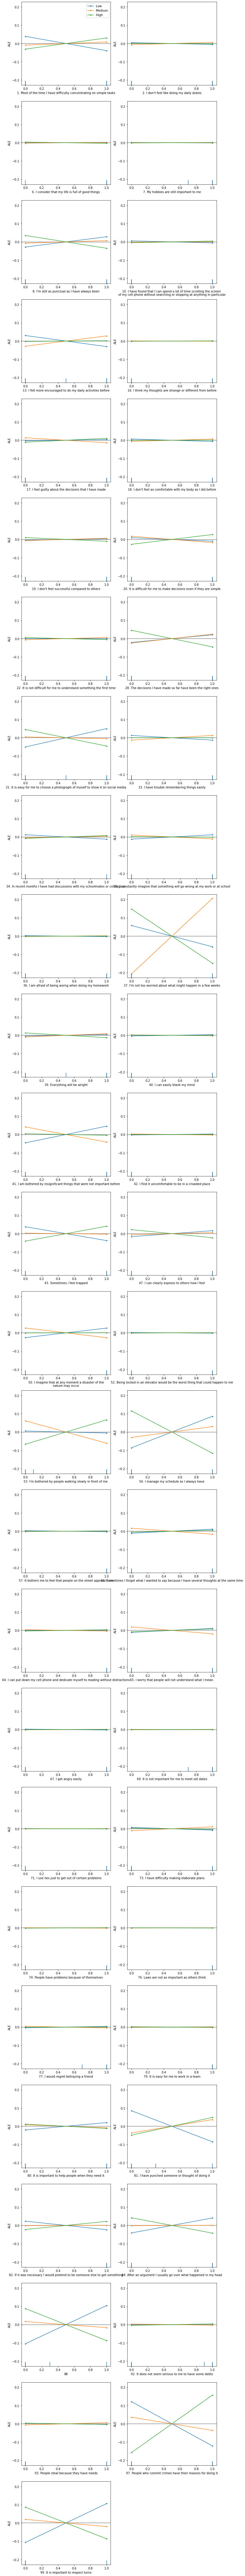

In [55]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 120});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [56]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## Dataset data reset.
dm.drop(dm.index[0: dm.shape[0]], axis = 0, inplace = True)

## Indexes are restored for later use.
dm.reset_index(inplace=True, drop=True)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.078007    0.060910            NA             NA          NA   
1          2  -0.009548   -0.002863            NA             NA          NA   
2          6   0.004662   -0.006732            NA             NA          NA   
3          7  -0.002550    0.002728            NA             NA          NA   
4          8   0.056086   -0.069883            NA             NA          NA   
5         10  -0.011161    0.009315            NA             NA          NA   
6         13  -0.060551    0.004189            NA             NA          NA   
7         16  -0.000957    0.002491            NA             NA          NA   
8         17   0.006024    0.021221            NA             NA          NA   
9         18  -0.013840    0.001035            NA             NA          NA   
10        19   0.007562   -0.020408            NA             NA          NA   
11        20  -0.018922    0.053429            NA             NA          NA   
12        22  -0.000985   -0.011379            NA             NA          NA   
13        28   0.042039   -0.090640            NA             NA          NA   
14        31   0.100081   -0.090169            NA             NA          NA   
15        33  -0.025636   -0.000395            NA             NA          NA   
16        34  -0.024138    0.015840            NA             NA          NA   
17        35   0.024024   -0.002917            NA             NA          NA   
18        36  -0.005089    0.001344            NA             NA          NA   
19        37  -0.116651   -0.297465            NA             NA          NA   
20        39   0.007830   -0.025644            NA             NA          NA   
21        40   0.007482   -0.002813            NA             NA          NA   
22        41   0.090997   -0.008499            NA             NA          NA   
23        42   0.005507    0.000417            NA             NA          NA   
24        43  -0.075720    0.081373            NA             NA          NA   
25        47   0.032606   -0.044468            NA             NA          NA   
26        50   0.052174    0.000956            NA             NA          NA   
27        52  -0.003530    0.001521            NA             NA          NA   
28        53  -0.010847    0.133234            NA             NA          NA   
29        56   0.172758   -0.232054            NA             NA          NA   
30        57  -0.005832    0.003360            NA             NA          NA   
31        61   0.022238    0.010717            NA             NA          NA   
32        64   0.000651    0.007177            NA             NA          NA   
33        65   0.021270    0.016541            NA             NA          NA   
34        67  -0.004709    0.001697            NA             NA          NA   
35        69  -0.001326    0.002261            NA             NA          NA   
36        71  -0.001712    0.000001            NA             NA          NA   
37        73  -0.015070   -0.006194            NA             NA          NA   
38        74  -0.000797    0.002747            NA             NA          NA   
39        76  -0.000559   -0.000642            NA             NA          NA   
40        77   0.007391    0.001862            NA             NA          NA   
41        79   0.003297   -0.003971            NA             NA          NA   
42        80   0.040535   -0.023198            NA             NA          NA   
43        81  -0.170393    0.097061            NA             NA          NA   
44        82  -0.046482    0.044328            NA             NA          NA   
45        84   0.081859   -0.084221            NA             NA          NA   
46        88   0.208674   -0.175313            NA             NA          NA   
47        92  -0.002075    0.008080            NA             NA          NA   
48        93  -0.005819   -0.006279            NA             NA          NA   
49  

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [57]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.078007    0.060910             0              1          NA   
1          2  -0.009548   -0.002863            NA             NA          NA   
2          6   0.004662   -0.006732            NA             NA          NA   
3          7  -0.002550    0.002728            NA             NA          NA   
4          8   0.056086   -0.069883             1              0          NA   
5         10  -0.011161    0.009315             0             NA          NA   
6         13  -0.060551    0.004189             0             NA          NA   
7         16  -0.000957    0.002491            NA             NA          NA   
8         17   0.006024    0.021221            NA              1          NA   
9         18  -0.013840    0.001035             0             NA          NA   
10        19   0.007562   -0.020408            NA              0          NA   
11        20  -0.018922    0.053429             0              1          NA   
12        22  -0.000985   -0.011379            NA              0          NA   
13        28   0.042039   -0.090640             1              0          NA   
14        31   0.100081   -0.090169             1              0          NA   
15        33  -0.025636   -0.000395             0             NA          NA   
16        34  -0.024138    0.015840             0              1          NA   
17        35   0.024024   -0.002917             1             NA          NA   
18        36  -0.005089    0.001344            NA             NA          NA   
19        37  -0.116651   -0.297465             0              0          NA   
20        39   0.007830   -0.025644            NA              0          NA   
21        40   0.007482   -0.002813            NA             NA          NA   
22        41   0.090997   -0.008499             1             NA          NA   
23        42   0.005507    0.000417            NA             NA          NA   
24        43  -0.075720    0.081373             0              1          NA   
25        47   0.032606   -0.044468             1              0          NA   
26        50   0.052174    0.000956             1             NA          NA   
27        52  -0.003530    0.001521            NA             NA          NA   
28        53  -0.010847    0.133234             0              1          NA   
29        56   0.172758   -0.232054             1              0          NA   
30        57  -0.005832    0.003360            NA             NA          NA   
31        61   0.022238    0.010717             1              1          NA   
32        64   0.000651    0.007177            NA             NA          NA   
33        65   0.021270    0.016541             1              1          NA   
34        67  -0.004709    0.001697            NA             NA          NA   
35        69  -0.001326    0.002261            NA             NA          NA   
36        71  -0.001712    0.000001            NA             NA          NA   
37        73  -0.015070   -0.006194             0             NA          NA   
38        74  -0.000797    0.002747            NA             NA          NA   
39        76  -0.000559   -0.000642            NA             NA          NA   
40        77   0.007391    0.001862            NA             NA          NA   
41        79   0.003297   -0.003971            NA             NA          NA   
42        80   0.040535   -0.023198             1              0          NA   
43        81  -0.170393    0.097061             0              1          NA   
44        82  -0.046482    0.044328             0              1          NA   
45        84   0.081859   -0.084221             1              0          NA   
46        88   0.208674   -0.175313             1              0          NA   
47        92  -0.002075    0.008080            NA             NA          NA   
48        93  -0.005819   -0.006279            NA             NA          NA   
49  

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [58]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        1  La mayor parte del tiempo tengo dificultad par...   1
1        2    No siento ganas de hacer mis deberes cotidianos   1
2        6   Considero que mi vida está llena de cosas buenas   0
3        7             Mis aficiones siguen siendo importante   0
4        8       Sigo siendo tan puntual como siempre he sido   0
5       10  Me he dado cuenta de que puedo pasar mucho tie...   1
6       13  Antes me sentía más animado para hacer mis act...   1
7       16  Creo que mis pensamientos son extraños o disti...   1
8       17    Siento culpa sobre las decisiones que he tomado   1
9       18  No me siento tan cómodo con mi cuerpo como me ...   1
10      19       Comparado con los demás no me siento exitoso   1
11      20  Me resulta complicado poder tomar decisiones a...   1
12      22      No se me dificulta entender algo a la primera   0
13      28  Las decisiones que he tomado hasta hoy han sid...   0
14      31  Me resulta fácil escoger una fotografía propia...   0
15      33  Tengo dificultades para recordar cosas con fac...   1
16      34  . En los últimos meses he tenido discusiones c...   1
17      35  Constantemente imagino que algo saldrá mal en ...   1
18      36    Tengo miedo de equivocarme al hacer mis deberes   1
19      37  No me preocupa tanto lo que pueda pasar en una...   0
20      39                                   Todo saldrá bien   0
21      40       Puedo poner mi mente en blanco con facilidad   0
22      41  Me molestan cosas insignificantes que antes no...   1
23      42  Me resulta incomodo estar en un espacio donde ...   1
24      43                         A veces me siento atrapado   1
25      47  Puedo expresarle con claridad a los otros cómo...   0
26      50  Imagino que en cualquier momento puede suceder...   1
27      52  Quedarme encerrado en un elevador sería de lo ...   1
28      53  Me molesta la gente que camina lento por la ca...   1
29      56       Manejo mis horarios como siempre lo he hecho   0
30      57  Me incomoda sentir que la gente en la calle se...   1
31      61  A veces olvido lo que quería decir porque teng...   1
32      64  Puedo dejar el celular y dedicarme a leer sin ...   0
33      65  Me preocupa que la gente no entienda lo que qu...   1
34      67                             Me enojo con facilidad   1
35      69  No me resulta importante cumplir con fechas es...   1
36      71  Utilizo las mentiras sólo para salir de alguno...   1
37      73    Tengo dificultades para hacer planes elaborados   1
38      74              La gente tiene problemas por su culpa   1
39      76  Las leyes no son tan importantes como otros creen   1
40      77             Me lamentaría al traicionar a un amigo   0
41      79                  Se me facilita trabajar en equipo   0
42      80  Es importante ayudar a la gente cuando lo nece...   0
43      81      He golpeado a alguien o he pensado en hacerlo   1
44      82  Si fuera necesario me haría pasar por alguien ...   1
45      84  Después de una discusión suelo repasar en mi c...   0
46      88  A veces la gente necesita de la fuerza física ...   1
47      92            No me parece grave tener algunas deudas   1
48      93             La gente roba porque tiene necesidades   1
49      97  La gente que comete crímenes tiene sus razones...   1
50      99                  Es importante respetar los turnos   0

We proceed to identify the anomadic questions present in the model present in this iteration.

In [59]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.078007    0.060910             0              1           0   
1          2  -0.009548   -0.002863            NA             NA          NA   
2          6   0.004662   -0.006732            NA             NA          NA   
3          7  -0.002550    0.002728            NA             NA          NA   
4          8   0.056086   -0.069883             1              0           0   
5         10  -0.011161    0.009315             0             NA           0   
6         13  -0.060551    0.004189             0             NA           0   
7         16  -0.000957    0.002491            NA             NA          NA   
8         17   0.006024    0.021221            NA              1          NA   
9         18  -0.013840    0.001035             0             NA           0   
10        19   0.007562   -0.020408            NA              0          NA   
11        20  -0.018922    0.053429             0              1           0   
12        22  -0.000985   -0.011379            NA              0          NA   
13        28   0.042039   -0.090640             1              0           0   
14        31   0.100081   -0.090169             1              0           0   
15        33  -0.025636   -0.000395             0             NA           0   
16        34  -0.024138    0.015840             0              1           0   
17        35   0.024024   -0.002917             1             NA           1   
18        36  -0.005089    0.001344            NA             NA          NA   
19        37  -0.116651   -0.297465             0              0           1   
20        39   0.007830   -0.025644            NA              0          NA   
21        40   0.007482   -0.002813            NA             NA          NA   
22        41   0.090997   -0.008499             1             NA           1   
23        42   0.005507    0.000417            NA             NA          NA   
24        43  -0.075720    0.081373             0              1           0   
25        47   0.032606   -0.044468             1              0           0   
26        50   0.052174    0.000956             1             NA           1   
27        52  -0.003530    0.001521            NA             NA          NA   
28        53  -0.010847    0.133234             0              1           0   
29        56   0.172758   -0.232054             1              0           0   
30        57  -0.005832    0.003360            NA             NA          NA   
31        61   0.022238    0.010717             1              1           1   
32        64   0.000651    0.007177            NA             NA          NA   
33        65   0.021270    0.016541             1              1           1   
34        67  -0.004709    0.001697            NA             NA          NA   
35        69  -0.001326    0.002261            NA             NA          NA   
36        71  -0.001712    0.000001            NA             NA          NA   
37        73  -0.015070   -0.006194             0             NA           0   
38        74  -0.000797    0.002747            NA             NA          NA   
39        76  -0.000559   -0.000642            NA             NA          NA   
40        77   0.007391    0.001862            NA             NA          NA   
41        79   0.003297   -0.003971            NA             NA          NA   
42        80   0.040535   -0.023198             1              0           0   
43        81  -0.170393    0.097061             0              1           0   
44        82  -0.046482    0.044328             0              1           0   
45        84   0.081859   -0.084221             1              0           0   
46        88   0.208674   -0.175313             1              0           1   
47        92  -0.002075    0.008080            NA             NA          NA   
48        93  -0.005819   -0.006279            NA             NA          NA   
49  

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [60]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
## Fixed anomalous question deletion.
question_anomaly [0] = 18

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[18, 88]

## Iteration 3

The third iteration of improvement of the model is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [61]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## The number of questions eliminated in the improvement process is retrieved..
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of the list of anomadic questions defined in the improvement process.
i = 0
for x in ds_delete['Question'].tolist():
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

1. Most of the time I have difficulty concentrating on simple tasks  \
0                                                    1                     
1                                                    1                     
2                                                    0                     
3                                                    0                     
4                                                    1                     
..                                                 ...                     
99                                                   1                     
100                                                  1                     
101                                                  0                     
102                                                  1                     
103                                                  1                     

     2. I don't feel like doing my daily duties  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             1   
..                                          ...   
99                                            1   
100                                           1   
101                                           0   
102                                           0   
103                                           1   

     6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     7. My hobbies are still important to me  \
0                                          1   
1                                          1   
2                                          1   
3                                          1   
4                                          0   
..                                       ...   
99                                         1   
100                                        1   
101                                        1   
102                                        1   
103                                        1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular  \
0                                                    0                                                                                                 
1                                                    0                                                                                                 
2                                                    1                                  

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [62]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [63]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [64]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [66]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.16329749103942653,
  0.18548387096774194,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304],
 [0.006619092595549127,
  0.038289905038962374,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

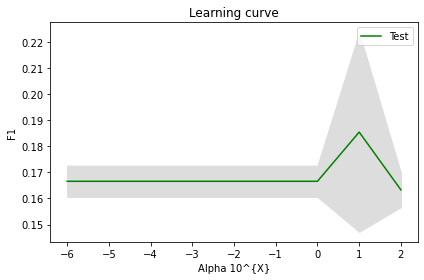

In [67]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [68]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.20974193548387093,
  0.41858015737272697,
  0.41988795518207284,
  0.38435893312054303,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304],
 [0.05628350642656671,
  0.11809659321212333,
  0.10996329827203792,
  0.09832856347428982,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

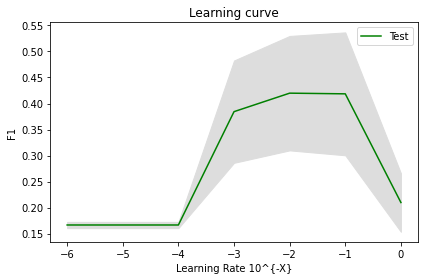

In [69]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [70]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [71]:
joblib.dump(mlp,"model_depression_i3.pkl")

['model_depression_i3.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

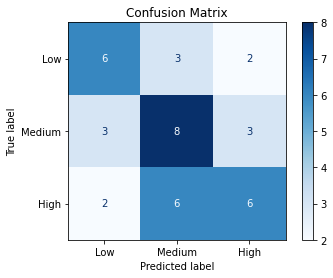

In [72]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [73]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 51.28205128205128 %

              precision    recall  f1-score   support

           0       0.55      0.55      0.55        11
           1       0.47      0.57      0.52        14
           2       0.55      0.43      0.48        14

    accuracy                           0.51        39
   macro avg       0.52      0.52      0.51        39
weighted avg       0.52      0.51      0.51        39



In [74]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  3,4,5,9,11,12,14,15,18,21,23,24,25,26,27,29,30...        51.282051   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0     0.545455  0.545455    0.545455         11     0.470588  0.571429   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0    0.516129         14     0.545455  0.428571        0.48         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [75]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

X does not have valid feature names, but MLPClassifier was fitted with feature names


The graphs of all the data present in the dataset used are shown.

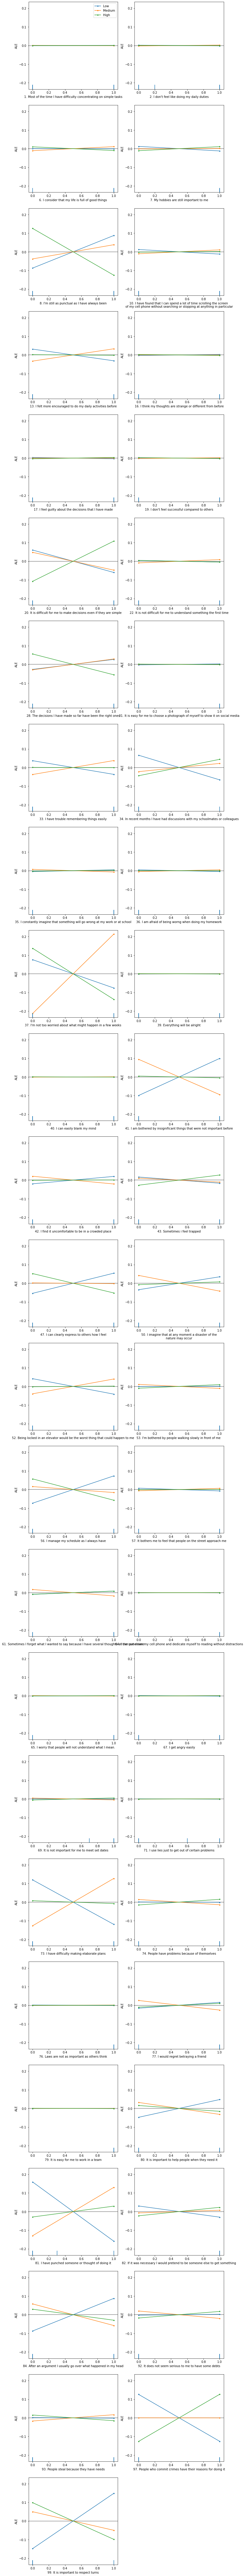

In [76]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 120});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [77]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## Dataset data reset.
dm.drop(dm.index[0: dm.shape[0]], axis = 0, inplace = True)

## Indexes are restored for later use.
dm.reset_index(inplace=True, drop=True)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1   0.001207    0.000402            NA             NA          NA   
1          2  -0.003263   -0.001352            NA             NA          NA   
2          6  -0.001740   -0.019800            NA             NA          NA   
3          7  -0.024418    0.021712            NA             NA          NA   
4          8   0.174823   -0.250881            NA             NA          NA   
5         10  -0.024491    0.003503            NA             NA          NA   
6         13  -0.062721   -0.003327            NA             NA          NA   
7         16   0.005942   -0.005420            NA             NA          NA   
8         17  -0.006815    0.007503            NA             NA          NA   
9         19   0.001586   -0.005236            NA             NA          NA   
10        20  -0.120252    0.215669            NA             NA          NA   
11        22  -0.008434   -0.009046            NA             NA          NA   
12        28   0.053512   -0.111674            NA             NA          NA   
13        31   0.005112   -0.003063            NA             NA          NA   
14        33  -0.073402   -0.001450            NA             NA          NA   
15        34  -0.132304    0.088084            NA             NA          NA   
16        35   0.009314    0.004828            NA             NA          NA   
17        36  -0.008830   -0.000738            NA             NA          NA   
18        37  -0.151860   -0.273727            NA             NA          NA   
19        39   0.002063   -0.001919            NA             NA          NA   
20        40  -0.000228   -0.001425            NA             NA          NA   
21        41   0.199182   -0.009364            NA             NA          NA   
22        42   0.039738    0.001803            NA             NA          NA   
23        43  -0.033284    0.054629            NA             NA          NA   
24        47   0.108021   -0.103944            NA             NA          NA   
25        50   0.069405    0.015002            NA             NA          NA   
26        52  -0.082881    0.003455            NA             NA          NA   
27        53   0.002201    0.019426            NA             NA          NA   
28        56   0.146358   -0.114473            NA             NA          NA   
29        57  -0.014604    0.001445            NA             NA          NA   
30        61   0.017514    0.016772            NA             NA          NA   
31        64  -0.001766    0.001574            NA             NA          NA   
32        65   0.001293    0.001054            NA             NA          NA   
33        67  -0.003065    0.001148            NA             NA          NA   
34        69  -0.001651    0.011130            NA             NA          NA   
35        71  -0.001851    0.000794            NA             NA          NA   
36        73  -0.238502   -0.015313            NA             NA          NA   
37        74  -0.002018    0.030273            NA             NA          NA   
38        76  -0.002629    0.000285            NA             NA          NA   
39        77   0.031563    0.020025            NA             NA          NA   
40        79   0.001548   -0.001784            NA             NA          NA   
41        80   0.095387   -0.031222            NA             NA          NA   
42        81  -0.317516    0.058183            NA             NA          NA   
43        82  -0.060007    0.045603            NA             NA          NA   
44        84   0.174896   -0.059001            NA             NA          NA   
45        92   0.004694    0.035131            NA             NA          NA   
46        93  -0.003497   -0.030294            NA             NA          NA   
47        97  -0.251863    0.252835            NA             NA          NA   
48        99   0.296284   -0.196661            NA             NA          NA   

   

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [78]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1   0.001207    0.000402            NA             NA          NA   
1          2  -0.003263   -0.001352            NA             NA          NA   
2          6  -0.001740   -0.019800            NA              0          NA   
3          7  -0.024418    0.021712             0              1          NA   
4          8   0.174823   -0.250881             1              0          NA   
5         10  -0.024491    0.003503             0             NA          NA   
6         13  -0.062721   -0.003327             0             NA          NA   
7         16   0.005942   -0.005420            NA             NA          NA   
8         17  -0.006815    0.007503            NA             NA          NA   
9         19   0.001586   -0.005236            NA             NA          NA   
10        20  -0.120252    0.215669             0              1          NA   
11        22  -0.008434   -0.009046            NA             NA          NA   
12        28   0.053512   -0.111674             1              0          NA   
13        31   0.005112   -0.003063            NA             NA          NA   
14        33  -0.073402   -0.001450             0             NA          NA   
15        34  -0.132304    0.088084             0              1          NA   
16        35   0.009314    0.004828            NA             NA          NA   
17        36  -0.008830   -0.000738            NA             NA          NA   
18        37  -0.151860   -0.273727             0              0          NA   
19        39   0.002063   -0.001919            NA             NA          NA   
20        40  -0.000228   -0.001425            NA             NA          NA   
21        41   0.199182   -0.009364             1             NA          NA   
22        42   0.039738    0.001803             1             NA          NA   
23        43  -0.033284    0.054629             0              1          NA   
24        47   0.108021   -0.103944             1              0          NA   
25        50   0.069405    0.015002             1              1          NA   
26        52  -0.082881    0.003455             0             NA          NA   
27        53   0.002201    0.019426            NA              1          NA   
28        56   0.146358   -0.114473             1              0          NA   
29        57  -0.014604    0.001445             0             NA          NA   
30        61   0.017514    0.016772             1              1          NA   
31        64  -0.001766    0.001574            NA             NA          NA   
32        65   0.001293    0.001054            NA             NA          NA   
33        67  -0.003065    0.001148            NA             NA          NA   
34        69  -0.001651    0.011130            NA              1          NA   
35        71  -0.001851    0.000794            NA             NA          NA   
36        73  -0.238502   -0.015313             0              0          NA   
37        74  -0.002018    0.030273            NA              1          NA   
38        76  -0.002629    0.000285            NA             NA          NA   
39        77   0.031563    0.020025             1              1          NA   
40        79   0.001548   -0.001784            NA             NA          NA   
41        80   0.095387   -0.031222             1              0          NA   
42        81  -0.317516    0.058183             0              1          NA   
43        82  -0.060007    0.045603             0              1          NA   
44        84   0.174896   -0.059001             1              0          NA   
45        92   0.004694    0.035131            NA              1          NA   
46        93  -0.003497   -0.030294            NA              0          NA   
47        97  -0.251863    0.252835             0              1          NA   
48        99   0.296284   -0.196661             1              0          NA   

   

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [79]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        1  La mayor parte del tiempo tengo dificultad par...   1
1        2    No siento ganas de hacer mis deberes cotidianos   1
2        6   Considero que mi vida está llena de cosas buenas   0
3        7             Mis aficiones siguen siendo importante   0
4        8       Sigo siendo tan puntual como siempre he sido   0
5       10  Me he dado cuenta de que puedo pasar mucho tie...   1
6       13  Antes me sentía más animado para hacer mis act...   1
7       16  Creo que mis pensamientos son extraños o disti...   1
8       17    Siento culpa sobre las decisiones que he tomado   1
9       19       Comparado con los demás no me siento exitoso   1
10      20  Me resulta complicado poder tomar decisiones a...   1
11      22      No se me dificulta entender algo a la primera   0
12      28  Las decisiones que he tomado hasta hoy han sid...   0
13      31  Me resulta fácil escoger una fotografía propia...   0
14      33  Tengo dificultades para recordar cosas con fac...   1
15      34  . En los últimos meses he tenido discusiones c...   1
16      35  Constantemente imagino que algo saldrá mal en ...   1
17      36    Tengo miedo de equivocarme al hacer mis deberes   1
18      37  No me preocupa tanto lo que pueda pasar en una...   0
19      39                                   Todo saldrá bien   0
20      40       Puedo poner mi mente en blanco con facilidad   0
21      41  Me molestan cosas insignificantes que antes no...   1
22      42  Me resulta incomodo estar en un espacio donde ...   1
23      43                         A veces me siento atrapado   1
24      47  Puedo expresarle con claridad a los otros cómo...   0
25      50  Imagino que en cualquier momento puede suceder...   1
26      52  Quedarme encerrado en un elevador sería de lo ...   1
27      53  Me molesta la gente que camina lento por la ca...   1
28      56       Manejo mis horarios como siempre lo he hecho   0
29      57  Me incomoda sentir que la gente en la calle se...   1
30      61  A veces olvido lo que quería decir porque teng...   1
31      64  Puedo dejar el celular y dedicarme a leer sin ...   0
32      65  Me preocupa que la gente no entienda lo que qu...   1
33      67                             Me enojo con facilidad   1
34      69  No me resulta importante cumplir con fechas es...   1
35      71  Utilizo las mentiras sólo para salir de alguno...   1
36      73    Tengo dificultades para hacer planes elaborados   1
37      74              La gente tiene problemas por su culpa   1
38      76  Las leyes no son tan importantes como otros creen   1
39      77             Me lamentaría al traicionar a un amigo   0
40      79                  Se me facilita trabajar en equipo   0
41      80  Es importante ayudar a la gente cuando lo nece...   0
42      81      He golpeado a alguien o he pensado en hacerlo   1
43      82  Si fuera necesario me haría pasar por alguien ...   1
44      84  Después de una discusión suelo repasar en mi c...   0
45      92            No me parece grave tener algunas deudas   1
46      93             La gente roba porque tiene necesidades   1
47      97  La gente que comete crímenes tiene sus razones...   1
48      99                  Es importante respetar los turnos   0

We proceed to identify the anomadic questions present in the model present in this iteration.

In [80]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1   0.001207    0.000402            NA             NA          NA   
1          2  -0.003263   -0.001352            NA             NA          NA   
2          6  -0.001740   -0.019800            NA              0          NA   
3          7  -0.024418    0.021712             0              1           1   
4          8   0.174823   -0.250881             1              0           0   
5         10  -0.024491    0.003503             0             NA           0   
6         13  -0.062721   -0.003327             0             NA           0   
7         16   0.005942   -0.005420            NA             NA          NA   
8         17  -0.006815    0.007503            NA             NA          NA   
9         19   0.001586   -0.005236            NA             NA          NA   
10        20  -0.120252    0.215669             0              1           0   
11        22  -0.008434   -0.009046            NA             NA          NA   
12        28   0.053512   -0.111674             1              0           0   
13        31   0.005112   -0.003063            NA             NA          NA   
14        33  -0.073402   -0.001450             0             NA           0   
15        34  -0.132304    0.088084             0              1           0   
16        35   0.009314    0.004828            NA             NA          NA   
17        36  -0.008830   -0.000738            NA             NA          NA   
18        37  -0.151860   -0.273727             0              0           1   
19        39   0.002063   -0.001919            NA             NA          NA   
20        40  -0.000228   -0.001425            NA             NA          NA   
21        41   0.199182   -0.009364             1             NA           1   
22        42   0.039738    0.001803             1             NA           1   
23        43  -0.033284    0.054629             0              1           0   
24        47   0.108021   -0.103944             1              0           0   
25        50   0.069405    0.015002             1              1           1   
26        52  -0.082881    0.003455             0             NA           0   
27        53   0.002201    0.019426            NA              1          NA   
28        56   0.146358   -0.114473             1              0           0   
29        57  -0.014604    0.001445             0             NA           0   
30        61   0.017514    0.016772             1              1           1   
31        64  -0.001766    0.001574            NA             NA          NA   
32        65   0.001293    0.001054            NA             NA          NA   
33        67  -0.003065    0.001148            NA             NA          NA   
34        69  -0.001651    0.011130            NA              1          NA   
35        71  -0.001851    0.000794            NA             NA          NA   
36        73  -0.238502   -0.015313             0              0           0   
37        74  -0.002018    0.030273            NA              1          NA   
38        76  -0.002629    0.000285            NA             NA          NA   
39        77   0.031563    0.020025             1              1           0   
40        79   0.001548   -0.001784            NA             NA          NA   
41        80   0.095387   -0.031222             1              0           0   
42        81  -0.317516    0.058183             0              1           0   
43        82  -0.060007    0.045603             0              1           0   
44        84   0.174896   -0.059001             1              0           0   
45        92   0.004694    0.035131            NA              1          NA   
46        93  -0.003497   -0.030294            NA              0          NA   
47        97  -0.251863    0.252835             0              1           0   
48        99   0.296284   -0.196661             1              0           0   

   

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [81]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[7, 73, 77, 93]

## Iteration 4

The fourth iteration of improvement of the model is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [82]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## The number of questions eliminated in the improvement process is retrieved..
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of the list of anomadic questions defined in the improvement process.
i = 0
for x in ds_delete['Question'].tolist():
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

1. Most of the time I have difficulty concentrating on simple tasks  \
0                                                    1                     
1                                                    1                     
2                                                    0                     
3                                                    0                     
4                                                    1                     
..                                                 ...                     
99                                                   1                     
100                                                  1                     
101                                                  0                     
102                                                  1                     
103                                                  1                     

     2. I don't feel like doing my daily duties  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             1   
..                                          ...   
99                                            1   
100                                           1   
101                                           0   
102                                           0   
103                                           1   

     6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular  \
0                                                    0                                                                                                 
1                                                    0                                                                                                 
2                                                    1                                                                                                 
3                                                    0                                                                                                 
4                                                    1                                                                                                 
..                                                 ...                                                                                                 
99                                                   1   

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [83]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [84]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [85]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [87]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.16774193548387095,
  0.16774193548387095,
  0.16774193548387095,
  0.16774193548387095,
  0.16774193548387095],
 [0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.007348981437341535,
  0.007348981437341535,
  0.007348981437341535,
  0.007348981437341535,
  0.007348981437341535])

We proceed to draw the learning curve graph according to the data obtained by the training.

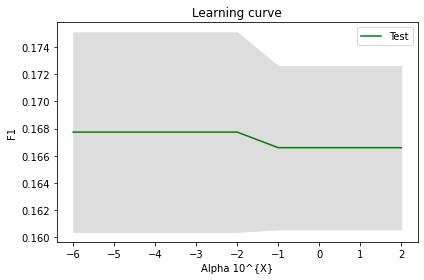

In [88]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [89]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.1983347752646974,
  0.3773906829324786,
  0.3804863654863655,
  0.35270886492248726,
  0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304],
 [0.04375335690240054,
  0.046788582345335804,
  0.06986756409093953,
  0.06320522188846132,
  0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

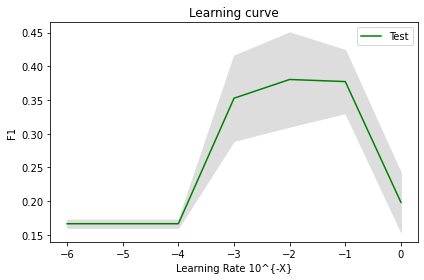

In [90]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [91]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [92]:
joblib.dump(mlp,"model_depression_i4.pkl")

['model_depression_i4.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

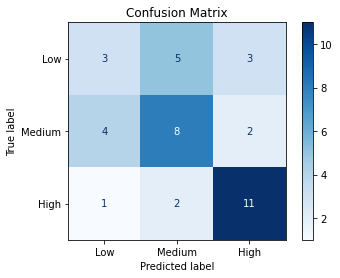

In [93]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [94]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 56.41025641025641 %

              precision    recall  f1-score   support

           0       0.38      0.27      0.32        11
           1       0.53      0.57      0.55        14
           2       0.69      0.79      0.73        14

    accuracy                           0.56        39
   macro avg       0.53      0.54      0.53        39
weighted avg       0.54      0.56      0.55        39



In [95]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  3,4,5,7,9,11,12,14,15,18,21,23,24,25,26,27,29,...        56.410256   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0        0.375  0.272727    0.315789         11     0.533333  0.571429   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0    0.551724         14       0.6875  0.785714    0.733333         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [96]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

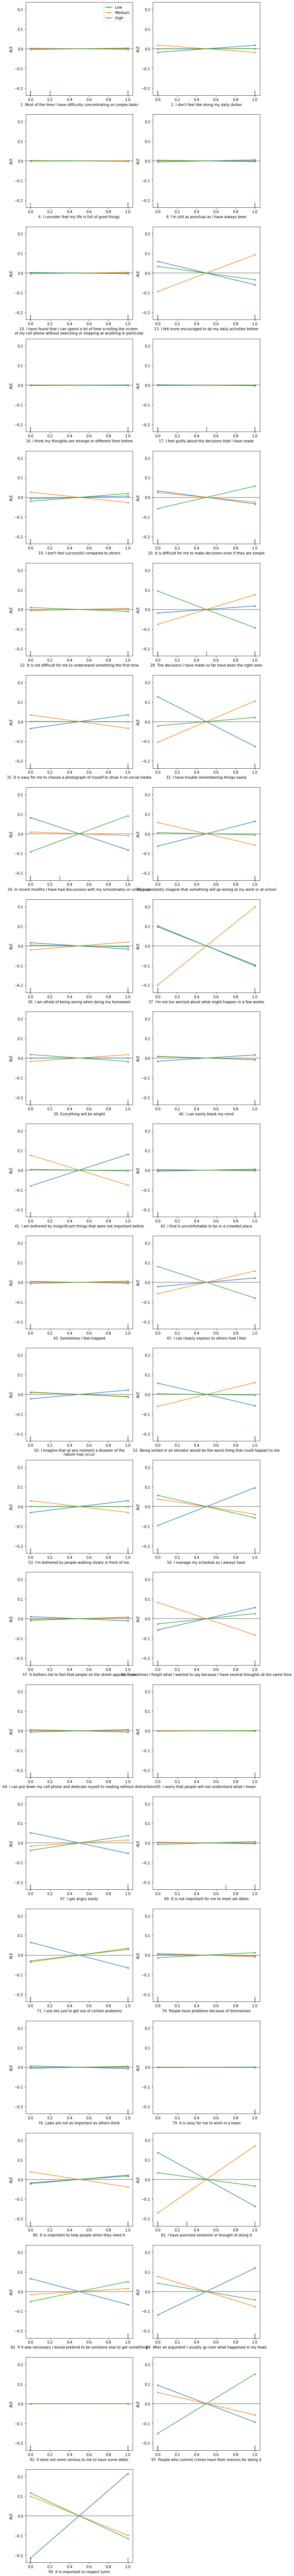

In [97]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 100});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [98]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## Dataset data reset.
dm.drop(dm.index[0: dm.shape[0]], axis = 0, inplace = True)

## Indexes are restored for later use.
dm.reset_index(inplace=True, drop=True)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.005658    0.007289            NA             NA          NA   
1          2   0.035605    0.001104            NA             NA          NA   
2          6   0.001768   -0.004013            NA             NA          NA   
3          8   0.010679   -0.007682            NA             NA          NA   
4         10  -0.005905   -0.002071            NA             NA          NA   
5         13  -0.118921   -0.068510            NA             NA          NA   
6         16   0.003128   -0.001701            NA             NA          NA   
7         17  -0.004524    0.002366            NA             NA          NA   
8         19   0.013410    0.039591            NA             NA          NA   
9         20  -0.065769    0.114342            NA             NA          NA   
10        22   0.009485   -0.019878            NA             NA          NA   
11        28   0.035889   -0.186879            NA             NA          NA   
12        31   0.069786   -0.001928            NA             NA          NA   
13        33  -0.253200    0.043075            NA             NA          NA   
14        34  -0.164692    0.183125            NA             NA          NA   
15        35   0.125798   -0.011542            NA             NA          NA   
16        36  -0.032517   -0.007737            NA             NA          NA   
17        37  -0.204283   -0.192918            NA             NA          NA   
18        39   0.000691   -0.035217            NA             NA          NA   
19        40   0.032347   -0.017326            NA             NA          NA   
20        41   0.160816   -0.008253            NA             NA          NA   
21        42   0.010430   -0.004348            NA             NA          NA   
22        43  -0.009198    0.012745            NA             NA          NA   
23        47   0.044421   -0.160421            NA             NA          NA   
24        50   0.044873   -0.024311            NA             NA          NA   
25        52  -0.114566   -0.006777            NA             NA          NA   
26        53   0.060416   -0.001009            NA             NA          NA   
27        56   0.192180   -0.114758            NA             NA          NA   
28        57  -0.021547    0.016673            NA             NA          NA   
29        61   0.113937    0.052717            NA             NA          NA   
30        64   0.012601   -0.012324            NA             NA          NA   
31        65  -0.001480    0.003523            NA             NA          NA   
32        67  -0.105329    0.074456            NA             NA          NA   
33        69  -0.005517    0.014441            NA             NA          NA   
34        71  -0.130116    0.058912            NA             NA          NA   
35        74  -0.007386    0.025424            NA             NA          NA   
36        76  -0.014414    0.010317            NA             NA          NA   
37        79   0.002579   -0.000653            NA             NA          NA   
38        80   0.043995    0.033522            NA             NA          NA   
39        81  -0.273770   -0.067501            NA             NA          NA   
40        82  -0.131939    0.101325            NA             NA          NA   
41        84   0.238387   -0.084991            NA             NA          NA   
42        92   0.000271    0.000444            NA             NA          NA   
43        97  -0.187947    0.302365            NA             NA          NA   
44        99   0.430081   -0.231515            NA             NA          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [99]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.005658    0.007289            NA             NA          NA   
1          2   0.035605    0.001104             1             NA          NA   
2          6   0.001768   -0.004013            NA             NA          NA   
3          8   0.010679   -0.007682             1             NA          NA   
4         10  -0.005905   -0.002071            NA             NA          NA   
5         13  -0.118921   -0.068510             0              0          NA   
6         16   0.003128   -0.001701            NA             NA          NA   
7         17  -0.004524    0.002366            NA             NA          NA   
8         19   0.013410    0.039591             1              1          NA   
9         20  -0.065769    0.114342             0              1          NA   
10        22   0.009485   -0.019878            NA              0          NA   
11        28   0.035889   -0.186879             1              0          NA   
12        31   0.069786   -0.001928             1             NA          NA   
13        33  -0.253200    0.043075             0              1          NA   
14        34  -0.164692    0.183125             0              1          NA   
15        35   0.125798   -0.011542             1              0          NA   
16        36  -0.032517   -0.007737             0             NA          NA   
17        37  -0.204283   -0.192918             0              0          NA   
18        39   0.000691   -0.035217            NA              0          NA   
19        40   0.032347   -0.017326             1              0          NA   
20        41   0.160816   -0.008253             1             NA          NA   
21        42   0.010430   -0.004348             1             NA          NA   
22        43  -0.009198    0.012745            NA              1          NA   
23        47   0.044421   -0.160421             1              0          NA   
24        50   0.044873   -0.024311             1              0          NA   
25        52  -0.114566   -0.006777             0             NA          NA   
26        53   0.060416   -0.001009             1             NA          NA   
27        56   0.192180   -0.114758             1              0          NA   
28        57  -0.021547    0.016673             0              1          NA   
29        61   0.113937    0.052717             1              1          NA   
30        64   0.012601   -0.012324             1              0          NA   
31        65  -0.001480    0.003523            NA             NA          NA   
32        67  -0.105329    0.074456             0              1          NA   
33        69  -0.005517    0.014441            NA              1          NA   
34        71  -0.130116    0.058912             0              1          NA   
35        74  -0.007386    0.025424            NA              1          NA   
36        76  -0.014414    0.010317             0              1          NA   
37        79   0.002579   -0.000653            NA             NA          NA   
38        80   0.043995    0.033522             1              1          NA   
39        81  -0.273770   -0.067501             0              0          NA   
40        82  -0.131939    0.101325             0              1          NA   
41        84   0.238387   -0.084991             1              0          NA   
42        92   0.000271    0.000444            NA             NA          NA   
43        97  -0.187947    0.302365             0              1          NA   
44        99   0.430081   -0.231515             1              0          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [100]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        1  La mayor parte del tiempo tengo dificultad par...   1
1        2    No siento ganas de hacer mis deberes cotidianos   1
2        6   Considero que mi vida está llena de cosas buenas   0
3        8       Sigo siendo tan puntual como siempre he sido   0
4       10  Me he dado cuenta de que puedo pasar mucho tie...   1
5       13  Antes me sentía más animado para hacer mis act...   1
6       16  Creo que mis pensamientos son extraños o disti...   1
7       17    Siento culpa sobre las decisiones que he tomado   1
8       19       Comparado con los demás no me siento exitoso   1
9       20  Me resulta complicado poder tomar decisiones a...   1
10      22      No se me dificulta entender algo a la primera   0
11      28  Las decisiones que he tomado hasta hoy han sid...   0
12      31  Me resulta fácil escoger una fotografía propia...   0
13      33  Tengo dificultades para recordar cosas con fac...   1
14      34  . En los últimos meses he tenido discusiones c...   1
15      35  Constantemente imagino que algo saldrá mal en ...   1
16      36    Tengo miedo de equivocarme al hacer mis deberes   1
17      37  No me preocupa tanto lo que pueda pasar en una...   0
18      39                                   Todo saldrá bien   0
19      40       Puedo poner mi mente en blanco con facilidad   0
20      41  Me molestan cosas insignificantes que antes no...   1
21      42  Me resulta incomodo estar en un espacio donde ...   1
22      43                         A veces me siento atrapado   1
23      47  Puedo expresarle con claridad a los otros cómo...   0
24      50  Imagino que en cualquier momento puede suceder...   1
25      52  Quedarme encerrado en un elevador sería de lo ...   1
26      53  Me molesta la gente que camina lento por la ca...   1
27      56       Manejo mis horarios como siempre lo he hecho   0
28      57  Me incomoda sentir que la gente en la calle se...   1
29      61  A veces olvido lo que quería decir porque teng...   1
30      64  Puedo dejar el celular y dedicarme a leer sin ...   0
31      65  Me preocupa que la gente no entienda lo que qu...   1
32      67                             Me enojo con facilidad   1
33      69  No me resulta importante cumplir con fechas es...   1
34      71  Utilizo las mentiras sólo para salir de alguno...   1
35      74              La gente tiene problemas por su culpa   1
36      76  Las leyes no son tan importantes como otros creen   1
37      79                  Se me facilita trabajar en equipo   0
38      80  Es importante ayudar a la gente cuando lo nece...   0
39      81      He golpeado a alguien o he pensado en hacerlo   1
40      82  Si fuera necesario me haría pasar por alguien ...   1
41      84  Después de una discusión suelo repasar en mi c...   0
42      92            No me parece grave tener algunas deudas   1
43      97  La gente que comete crímenes tiene sus razones...   1
44      99                  Es importante respetar los turnos   0

We proceed to identify the anomadic questions present in the model present in this iteration.

In [101]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.005658    0.007289            NA             NA          NA   
1          2   0.035605    0.001104             1             NA           1   
2          6   0.001768   -0.004013            NA             NA          NA   
3          8   0.010679   -0.007682             1             NA           0   
4         10  -0.005905   -0.002071            NA             NA          NA   
5         13  -0.118921   -0.068510             0              0           0   
6         16   0.003128   -0.001701            NA             NA          NA   
7         17  -0.004524    0.002366            NA             NA          NA   
8         19   0.013410    0.039591             1              1           1   
9         20  -0.065769    0.114342             0              1           0   
10        22   0.009485   -0.019878            NA              0          NA   
11        28   0.035889   -0.186879             1              0           0   
12        31   0.069786   -0.001928             1             NA           0   
13        33  -0.253200    0.043075             0              1           0   
14        34  -0.164692    0.183125             0              1           0   
15        35   0.125798   -0.011542             1              0           1   
16        36  -0.032517   -0.007737             0             NA           0   
17        37  -0.204283   -0.192918             0              0           1   
18        39   0.000691   -0.035217            NA              0          NA   
19        40   0.032347   -0.017326             1              0           0   
20        41   0.160816   -0.008253             1             NA           1   
21        42   0.010430   -0.004348             1             NA           1   
22        43  -0.009198    0.012745            NA              1          NA   
23        47   0.044421   -0.160421             1              0           0   
24        50   0.044873   -0.024311             1              0           1   
25        52  -0.114566   -0.006777             0             NA           0   
26        53   0.060416   -0.001009             1             NA           1   
27        56   0.192180   -0.114758             1              0           0   
28        57  -0.021547    0.016673             0              1           0   
29        61   0.113937    0.052717             1              1           1   
30        64   0.012601   -0.012324             1              0           0   
31        65  -0.001480    0.003523            NA             NA          NA   
32        67  -0.105329    0.074456             0              1           0   
33        69  -0.005517    0.014441            NA              1          NA   
34        71  -0.130116    0.058912             0              1           0   
35        74  -0.007386    0.025424            NA              1          NA   
36        76  -0.014414    0.010317             0              1           0   
37        79   0.002579   -0.000653            NA             NA          NA   
38        80   0.043995    0.033522             1              1           0   
39        81  -0.273770   -0.067501             0              0           0   
40        82  -0.131939    0.101325             0              1           0   
41        84   0.238387   -0.084991             1              0           0   
42        92   0.000271    0.000444            NA             NA          NA   
43        97  -0.187947    0.302365             0              1           0   
44        99   0.430081   -0.231515             1              0           0   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5             1  
6            NA  
7            NA  
8             0  
9             0  
10            0  
11            0  
12           NA  
13            0  
14            0  
15            1  
16           NA  

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [102]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[13, 35, 50, 80, 81]

## Iteration 5

The fifth iteration of improvement of the model is carried out.

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [103]:
## Loading data from the dataset
df = pd.read_csv(path_dataset)
ds = pd.read_csv(path_dataset_qs)

## The number of questions eliminated in the improvement process is retrieved..
ds_delete = ds[ds.Status == "Delete"]
ds_delete.reset_index(inplace=True, drop=True)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Elimination of the list of anomadic questions defined in the improvement process.
i = 0
for x in ds_delete['Question'].tolist():
    df.drop(df.columns[x - (i + 1)], axis = 1, inplace = True)
    i += 1

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_cols = df.columns [0:-1]
label = df.columns [-1]
X = df [train_cols]
y = df [label]

## The prepared data of the dataset is printed.
df

1. Most of the time I have difficulty concentrating on simple tasks  \
0                                                    1                     
1                                                    1                     
2                                                    0                     
3                                                    0                     
4                                                    1                     
..                                                 ...                     
99                                                   1                     
100                                                  1                     
101                                                  0                     
102                                                  1                     
103                                                  1                     

     2. I don't feel like doing my daily duties  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             1   
..                                          ...   
99                                            1   
100                                           1   
101                                           0   
102                                           0   
103                                           1   

     6. I consider that my life is full of good things  \
0                                                    1   
1                                                    1   
2                                                    1   
3                                                    1   
4                                                    1   
..                                                 ...   
99                                                   1   
100                                                  1   
101                                                  1   
102                                                  1   
103                                                  1   

     8. I'm still as punctual as I have always been  \
0                                                 1   
1                                                 1   
2                                                 0   
3                                                 1   
4                                                 1   
..                                              ...   
99                                                1   
100                                               0   
101                                               0   
102                                               1   
103                                               0   

     10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular  \
0                                                    0                                                                                                 
1                                                    0                                                                                                 
2                                                    1                                                                                                 
3                                                    0                                                                                                 
4                                                    1                                                                                                 
..                                                 ...                                                                                                 
99                                                   1   

## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [104]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [105]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [106]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [108]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_normal

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = regul_param, 
             learning_rate = 'constant', learning_rate_init = 0.0001, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.17885304659498208,
  0.20809774825347685,
  0.22632248647821504,
  0.22869549352307975,
  0.22869549352307975,
  0.22869549352307975,
  0.22869549352307975,
  0.22869549352307975,
  0.22869549352307975],
 [0.02776424690681508,
  0.051210189143531634,
  0.029674948814614122,
  0.025407008488080713,
  0.025407008488080713,
  0.025407008488080713,
  0.025407008488080713,
  0.025407008488080713,
  0.025407008488080713])

We proceed to draw the learning curve graph according to the data obtained by the training.

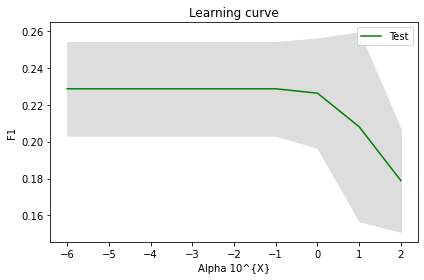

In [109]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [110]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []
regul_param_range = regul_param_alpha

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 1, 
             learning_rate = 'constant', learning_rate_init = regul_param, max_iter = 100000, random_state = seed)
    
    scores = cross_val_score(mlp, X, y, cv = 5, scoring = 'f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.1832616487455197,
  0.4682601173622845,
  0.40050805403746575,
  0.41746001504515434,
  0.22632248647821504,
  0.16659498207885304,
  0.16659498207885304],
 [0.033907946664589496,
  0.05327995216329938,
  0.08828138759982909,
  0.08846369936077947,
  0.029674948814614122,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

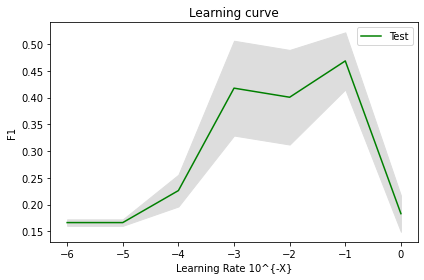

In [111]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color = "g", label = "Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color = "#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc = "best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [112]:
## The alpha parameter value is changed to 0.001, learning_rate_init to 0.1, and the seed random_state value to 42.
mlp = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', alpha = 0.001, 
             learning_rate = 'constant', learning_rate_init = 0.1, max_iter = 100000, random_state = 42)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(10,),
              learning_rate_init=0.1, max_iter=100000, random_state=42)

We safeguard the final generated model

In [113]:
joblib.dump(mlp,"model_depression_i5.pkl")

['model_depression_i5.pkl']

## Generation of the confusion matrix of the model

We obtain the statistics of the final model to generate its confusion matrix.

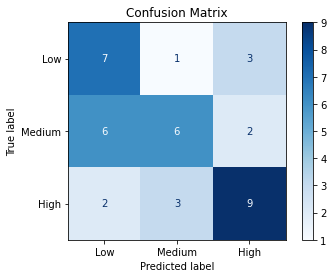

In [114]:
## The data for the generation of the confession matrix are defined.
confusion_matrix = ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, display_labels = target_names,
                                                         cmap = plt.cm.Blues)
confusion_matrix.ax_.set_title("Confusion Matrix")
plt.show()

We get the detailed statistics of the final model.

In [115]:
## The necessary detailed prediction is generated.
y_pred = mlp.predict(X_test)

## The detailed statistics of the model are printed.
print('Classification accuracy =',accuracy_score(y_test,y_pred) * 100,'%\n')
print(classification_report(y_test,y_pred))

Classification accuracy = 56.41025641025641 %

              precision    recall  f1-score   support

           0       0.47      0.64      0.54        11
           1       0.60      0.43      0.50        14
           2       0.64      0.64      0.64        14

    accuracy                           0.56        39
   macro avg       0.57      0.57      0.56        39
weighted avg       0.58      0.56      0.56        39



In [116]:
accuracy = accuracy_score(y_test,y_pred) * 100
clf_rep = precision_recall_fscore_support(y_test,y_pred)

## All the metrics of the confusion matrix are obtained.
metrics = [",".join(map(str, ds_delete['Question'].tolist())), accuracy, clf_rep[0][0], clf_rep[1][0],
           clf_rep[2][0], clf_rep[3][0],clf_rep[0][1], clf_rep[1][1], clf_rep[2][1], clf_rep[3][1],
           clf_rep[0][2], clf_rep[1][2], clf_rep[2][2], clf_rep[3][2]]

## The names of the columns of the dataset are defined.
columns = ['Question','Acurracy global','Precision_0','Recall_0','F1_score_0', 'Support_0',
           'Precision_1','Recall_1','F1_score_1', 'Support_1','Precision_2','Recall_2','F1_score_2','Support_2']

## A new row of the dataset is generated with all the data.
data = pd.DataFrame([metrics], columns = columns)

## The data is saved to the dataset.
data.to_csv(path_dataset_qd, mode = 'a', header = False, index = False)

data

Question  Acurracy global  \
0  3,4,5,7,9,11,12,13,14,15,18,21,23,24,25,26,27,...        56.410256   

   Precision_0  Recall_0  F1_score_0  Support_0  Precision_1  Recall_1  \
0     0.466667  0.636364    0.538462         11          0.6  0.428571   

   F1_score_1  Support_1  Precision_2  Recall_2  F1_score_2  Support_2  
0         0.5         14     0.642857  0.642857    0.642857         14

## Model explainability process

In analysis of the model through the results obtained by ALE, it is possible to identify the behavior of the neural network.

In [117]:
## The necessary parameters for the use of ALE are established according to the model.
proba_fun_lr = mlp.predict_proba
proba_ale_lr = ALE(proba_fun_lr, feature_names = train_cols, target_names = target_names)
proba_exp_lr = proba_ale_lr.explain(X_train.to_numpy())

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

The graphs of all the data present in the dataset used are shown.

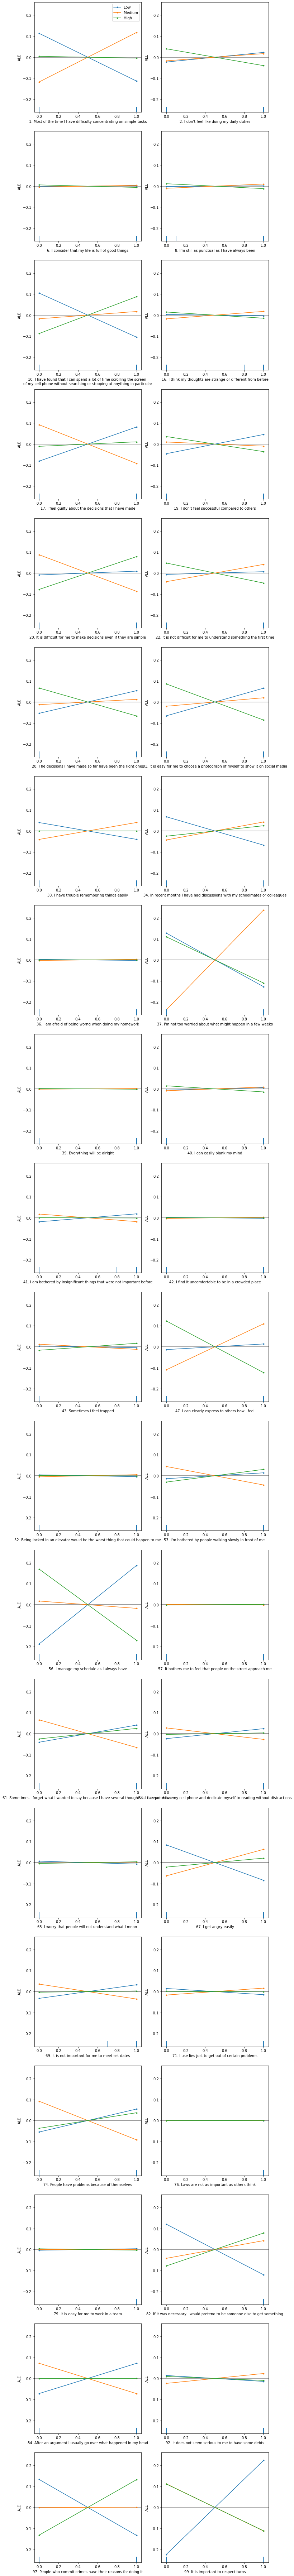

In [118]:
plot_ale(proba_exp_lr, n_cols=2, features=list(range(df.shape[1]-1)),fig_kw={'figwidth': 10, 'figheight': 100});

## Slope Analysis of ALE Plots

We proceed to obtain the graphs to obtain the slopes of the data in the Low and High class.

In [119]:
## The question metrics dataset is loaded.
dm = pd.read_csv(path_dataset_qm)

## Dataset data reset.
dm.drop(dm.index[0: dm.shape[0]], axis = 0, inplace = True)

## Indexes are restored for later use.
dm.reset_index(inplace=True, drop=True)

## The number of questions used in the iteration is retrieved.
ds_item = ds[ds.Status == "In use"]
ds_item.reset_index(inplace=True, drop=True)

## We get the slopes from the ALE data.
for i in range(df.shape[1]-1):
    slope_low = proba_exp_lr ['data']['ale_values'][i][1][0] - proba_exp_lr ['data']['ale_values'][i][0][0]
    slope_high = proba_exp_lr ['data']['ale_values'][i][1][2] - proba_exp_lr ['data']['ale_values'][i][0][2]
    
    dm = dm.append({'Question': ds_item.loc[i, "Question"], 'Slope Low': slope_low, 'Slope High': slope_high,
                   'Threshold Low': 'NA', 'Threshold High': 'NA', 'Anomaly Low': 'NA', 'Anomaly High': 'NA'},
                   ignore_index=True)

dm

The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The Explanation object is not a dictionary anymore and accessing elements should be done

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.227077   -0.008421            NA             NA          NA   
1          2   0.045987   -0.080295            NA             NA          NA   
2          6   0.004204   -0.012150            NA             NA          NA   
3          8   0.003336   -0.023510            NA             NA          NA   
4         10  -0.209547    0.175098            NA             NA          NA   
5         16  -0.006255   -0.029325            NA             NA          NA   
6         17   0.162532    0.021486            NA             NA          NA   
7         19   0.091447   -0.071882            NA             NA          NA   
8         20   0.017880    0.156028            NA             NA          NA   
9         22   0.013127   -0.095481            NA             NA          NA   
10        28   0.107662   -0.132780            NA             NA          NA   
11        31   0.131708   -0.172085            NA             NA          NA   
12        33  -0.080075   -0.000487            NA             NA          NA   
13        34  -0.135254    0.049533            NA             NA          NA   
14        36  -0.005072   -0.000235            NA             NA          NA   
15        37  -0.255245   -0.220103            NA             NA          NA   
16        39   0.000447   -0.003457            NA             NA          NA   
17        40   0.011465   -0.029112            NA             NA          NA   
18        41   0.037772   -0.001884            NA             NA          NA   
19        42  -0.004741   -0.001193            NA             NA          NA   
20        43  -0.008710    0.033144            NA             NA          NA   
21        47   0.026877   -0.245972            NA             NA          NA   
22        52  -0.008871   -0.001439            NA             NA          NA   
23        53   0.027943    0.060361            NA             NA          NA   
24        56   0.373460   -0.338700            NA             NA          NA   
25        57  -0.000572    0.002802            NA             NA          NA   
26        61   0.081550    0.049994            NA             NA          NA   
27        64   0.047546    0.007331            NA             NA          NA   
28        65  -0.013686    0.008034            NA             NA          NA   
29        67  -0.168770    0.042539            NA             NA          NA   
30        69   0.064901    0.006131            NA             NA          NA   
31        71  -0.029679   -0.003310            NA             NA          NA   
32        74   0.109466    0.074090            NA             NA          NA   
33        76  -0.000654    0.001010            NA             NA          NA   
34        79   0.007452   -0.006839            NA             NA          NA   
35        82  -0.241019    0.156662            NA             NA          NA   
36        84   0.143712    0.000665            NA             NA          NA   
37        92  -0.028286   -0.018928            NA             NA          NA   
38        97  -0.266074    0.263770            NA             NA          NA   
39        99   0.447654   -0.223161            NA             NA          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21           NA  
22           NA  
23           NA  
24           NA  
25           NA  
26           NA  
27           NA  
28           NA  
29           NA  
30           NA  
31           NA  
32           NA  
33           NA  
34           NA  
35           NA  
36           NA  
37           NA  
38           NA  
39 

## Slope analysis and threshold application

The slope obtained is analyzed and those that are above or below the positive and negative threshold are selected.

In [120]:
for i in range(df.shape[1]-1):
    
    ## The slopes are selected according to the values of the thresholds of the Low class
    if dm.loc[i, "Slope Low"] >= positive_threshold:
        dm.loc[i, "Threshold Low"] = 1
    elif dm.loc[i, "Slope Low"] <= negative_threshold:
        dm.loc[i, "Threshold Low"] = 0
    
    ## The slopes are selected according to the values of the thresholds of the High class
    if dm.loc[i, "Slope High"] >= positive_threshold:
        dm.loc[i, "Threshold High"] = 1
    elif dm.loc[i, "Slope High"] <= negative_threshold:
        dm.loc[i, "Threshold High"] = 0
        
dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.227077   -0.008421             0             NA          NA   
1          2   0.045987   -0.080295             1              0          NA   
2          6   0.004204   -0.012150            NA              0          NA   
3          8   0.003336   -0.023510            NA              0          NA   
4         10  -0.209547    0.175098             0              1          NA   
5         16  -0.006255   -0.029325            NA              0          NA   
6         17   0.162532    0.021486             1              1          NA   
7         19   0.091447   -0.071882             1              0          NA   
8         20   0.017880    0.156028             1              1          NA   
9         22   0.013127   -0.095481             1              0          NA   
10        28   0.107662   -0.132780             1              0          NA   
11        31   0.131708   -0.172085             1              0          NA   
12        33  -0.080075   -0.000487             0             NA          NA   
13        34  -0.135254    0.049533             0              1          NA   
14        36  -0.005072   -0.000235            NA             NA          NA   
15        37  -0.255245   -0.220103             0              0          NA   
16        39   0.000447   -0.003457            NA             NA          NA   
17        40   0.011465   -0.029112             1              0          NA   
18        41   0.037772   -0.001884             1             NA          NA   
19        42  -0.004741   -0.001193            NA             NA          NA   
20        43  -0.008710    0.033144            NA              1          NA   
21        47   0.026877   -0.245972             1              0          NA   
22        52  -0.008871   -0.001439            NA             NA          NA   
23        53   0.027943    0.060361             1              1          NA   
24        56   0.373460   -0.338700             1              0          NA   
25        57  -0.000572    0.002802            NA             NA          NA   
26        61   0.081550    0.049994             1              1          NA   
27        64   0.047546    0.007331             1             NA          NA   
28        65  -0.013686    0.008034             0             NA          NA   
29        67  -0.168770    0.042539             0              1          NA   
30        69   0.064901    0.006131             1             NA          NA   
31        71  -0.029679   -0.003310             0             NA          NA   
32        74   0.109466    0.074090             1              1          NA   
33        76  -0.000654    0.001010            NA             NA          NA   
34        79   0.007452   -0.006839            NA             NA          NA   
35        82  -0.241019    0.156662             0              1          NA   
36        84   0.143712    0.000665             1             NA          NA   
37        92  -0.028286   -0.018928             0              0          NA   
38        97  -0.266074    0.263770             0              1          NA   
39        99   0.447654   -0.223161             1              0          NA   

   Anomaly High  
0            NA  
1            NA  
2            NA  
3            NA  
4            NA  
5            NA  
6            NA  
7            NA  
8            NA  
9            NA  
10           NA  
11           NA  
12           NA  
13           NA  
14           NA  
15           NA  
16           NA  
17           NA  
18           NA  
19           NA  
20           NA  
21           NA  
22           NA  
23           NA  
24           NA  
25           NA  
26           NA  
27           NA  
28           NA  
29           NA  
30           NA  
31           NA  
32           NA  
33           NA  
34           NA  
35           NA  
36           NA  
37           NA  
38           NA  
39 

## Analysis and determination of anomalous questions

The anomalous questions present in the model are determined based on their slope and expected response from the expert.

In [121]:
## The dataset of expected responses is loaded.
da = pd.read_csv(path_dataset_qa)

## Delete list of questions deleted in this iteration.
i = 0
for x in ds_delete['Question']:
    da.drop(da.index[x - (i + 1)], axis = 0, inplace = True)
    i += 1

## Indexes are restored for later use.
da.reset_index(inplace=True, drop=True)

da

Numero                                           Pregunta  RE
0        1  La mayor parte del tiempo tengo dificultad par...   1
1        2    No siento ganas de hacer mis deberes cotidianos   1
2        6   Considero que mi vida está llena de cosas buenas   0
3        8       Sigo siendo tan puntual como siempre he sido   0
4       10  Me he dado cuenta de que puedo pasar mucho tie...   1
5       16  Creo que mis pensamientos son extraños o disti...   1
6       17    Siento culpa sobre las decisiones que he tomado   1
7       19       Comparado con los demás no me siento exitoso   1
8       20  Me resulta complicado poder tomar decisiones a...   1
9       22      No se me dificulta entender algo a la primera   0
10      28  Las decisiones que he tomado hasta hoy han sid...   0
11      31  Me resulta fácil escoger una fotografía propia...   0
12      33  Tengo dificultades para recordar cosas con fac...   1
13      34  . En los últimos meses he tenido discusiones c...   1
14      36    Tengo miedo de equivocarme al hacer mis deberes   1
15      37  No me preocupa tanto lo que pueda pasar en una...   0
16      39                                   Todo saldrá bien   0
17      40       Puedo poner mi mente en blanco con facilidad   0
18      41  Me molestan cosas insignificantes que antes no...   1
19      42  Me resulta incomodo estar en un espacio donde ...   1
20      43                         A veces me siento atrapado   1
21      47  Puedo expresarle con claridad a los otros cómo...   0
22      52  Quedarme encerrado en un elevador sería de lo ...   1
23      53  Me molesta la gente que camina lento por la ca...   1
24      56       Manejo mis horarios como siempre lo he hecho   0
25      57  Me incomoda sentir que la gente en la calle se...   1
26      61  A veces olvido lo que quería decir porque teng...   1
27      64  Puedo dejar el celular y dedicarme a leer sin ...   0
28      65  Me preocupa que la gente no entienda lo que qu...   1
29      67                             Me enojo con facilidad   1
30      69  No me resulta importante cumplir con fechas es...   1
31      71  Utilizo las mentiras sólo para salir de alguno...   1
32      74              La gente tiene problemas por su culpa   1
33      76  Las leyes no son tan importantes como otros creen   1
34      79                  Se me facilita trabajar en equipo   0
35      82  Si fuera necesario me haría pasar por alguien ...   1
36      84  Después de una discusión suelo repasar en mi c...   0
37      92            No me parece grave tener algunas deudas   1
38      97  La gente que comete crímenes tiene sus razones...   1
39      99                  Es importante respetar los turnos   0

We proceed to identify the anomadic questions present in the model present in this iteration.

In [122]:
for i in range(df.shape[1]-1):
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the Low class.
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 1
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly Low"] = 0
    if dm.loc[i, "Threshold Low"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly Low"] = 1
    
    ## It is determined if it is anomalous according to the parameters of the expected response of the High class.
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 1 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 1
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 0:
        dm.loc[i, "Anomaly High"] = 0
    if dm.loc[i, "Threshold High"] == 0 and da.loc[i, "RE"] == 1:
        dm.loc[i, "Anomaly High"] = 1
        
## We save the slopes obtained in the corresponding dataset.
dm.to_csv(path_dataset_qm, index = False)

dm

Question  Slope Low  Slope High Threshold Low Threshold High Anomaly Low  \
0          1  -0.227077   -0.008421             0             NA           0   
1          2   0.045987   -0.080295             1              0           1   
2          6   0.004204   -0.012150            NA              0          NA   
3          8   0.003336   -0.023510            NA              0          NA   
4         10  -0.209547    0.175098             0              1           0   
5         16  -0.006255   -0.029325            NA              0          NA   
6         17   0.162532    0.021486             1              1           1   
7         19   0.091447   -0.071882             1              0           1   
8         20   0.017880    0.156028             1              1           1   
9         22   0.013127   -0.095481             1              0           0   
10        28   0.107662   -0.132780             1              0           0   
11        31   0.131708   -0.172085             1              0           0   
12        33  -0.080075   -0.000487             0             NA           0   
13        34  -0.135254    0.049533             0              1           0   
14        36  -0.005072   -0.000235            NA             NA          NA   
15        37  -0.255245   -0.220103             0              0           1   
16        39   0.000447   -0.003457            NA             NA          NA   
17        40   0.011465   -0.029112             1              0           0   
18        41   0.037772   -0.001884             1             NA           1   
19        42  -0.004741   -0.001193            NA             NA          NA   
20        43  -0.008710    0.033144            NA              1          NA   
21        47   0.026877   -0.245972             1              0           0   
22        52  -0.008871   -0.001439            NA             NA          NA   
23        53   0.027943    0.060361             1              1           1   
24        56   0.373460   -0.338700             1              0           0   
25        57  -0.000572    0.002802            NA             NA          NA   
26        61   0.081550    0.049994             1              1           1   
27        64   0.047546    0.007331             1             NA           0   
28        65  -0.013686    0.008034             0             NA           0   
29        67  -0.168770    0.042539             0              1           0   
30        69   0.064901    0.006131             1             NA           1   
31        71  -0.029679   -0.003310             0             NA           0   
32        74   0.109466    0.074090             1              1           1   
33        76  -0.000654    0.001010            NA             NA          NA   
34        79   0.007452   -0.006839            NA             NA          NA   
35        82  -0.241019    0.156662             0              1           0   
36        84   0.143712    0.000665             1             NA           0   
37        92  -0.028286   -0.018928             0              0           0   
38        97  -0.266074    0.263770             0              1           0   
39        99   0.447654   -0.223161             1              0           0   

   Anomaly High  
0            NA  
1             1  
2             0  
3             0  
4             0  
5             1  
6             0  
7             1  
8             0  
9             0  
10            0  
11            0  
12           NA  
13            0  
14           NA  
15            0  
16           NA  
17            0  
18           NA  
19           NA  
20            0  
21            0  
22           NA  
23            0  
24            0  
25           NA  
26            0  
27           NA  
28           NA  
29            0  
30           NA  
31           NA  
32            0  
33           NA  
34           NA  
35            0  
36           NA  
37            1  
38            0  
39 

## Removing identified anomadic questions from the model

We proceed to eliminate the identified anomadic questions so as not to use them in the next iteration.

In [123]:
## Local variable for the elimination of the anomaly questions.
question_anomaly = []

if selection_mode == 1:
    ## Questions that are anomaly in the Low class are retrieved.
    dm_delete = dm[dm['Anomaly Low'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 2:
    ## Questions that are anomaly in the High class are retrieved.
    dm_delete = dm[dm['Anomaly High'] == 1]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 3:
    ## Questions that are anomalous in the Low or High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) | (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 4:
    ## Questions that are anomalous in the Low and High class are retrieved.
    dm_delete = dm[(dm['Anomaly Low'] == 1) & (dm['Anomaly High'] == 1)]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()
    
if selection_mode == 5:
    ## Questions that are outside the thresholds are retrieved in both the Low and High class.
    dm_delete = dm[(dm['Anomaly Low'] == 'NA') & (dm['Anomaly High'] == 'NA')]
    dm_delete.reset_index(inplace=True, drop=True)
    question_anomaly = dm_delete['Question'].tolist()

## Removal of anomalous questions selected by selection_mode.
for x in question_anomaly:

    ## Status change of the deleted question in the respective auxiliary dataset.
    ds.loc[x - 1,'Status'] = 'Delete'

## Save the changed statuses in the dataset.
ds.to_csv(path_dataset_qs, index = False)

## The selected blank questions are printed according to the selection_mode.
question_anomaly

[2, 16, 19, 92]

## Generation of final graphs from the results obtained by the improvement process

Different graphs are generated with the aim of clearly illustrating the data obtained from the model improvement process.

In [179]:
## Loading data from the dataset.
df = pd.read_csv(path_dataset)
dd = pd.read_csv(path_dataset_qd)

## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

All the data necessary to generate the graphs are obtained.

In [198]:
## Local variables for graph generation.
total_question = []
global_accuracy = []
total_delete = []
recall_low = []
recall_medium = []
recall_high = []

## Get the total number of iterations.
iterations = list(map(str, list(range(1, (dd.shape[0] + 1)))))

## Obtaining data from the dataset.
for x in range(dd.shape[0]):
    
    ## The total number of questions used in each iteration is obtained.
    total_question.append((df.shape[1] - 1) - len((dd.loc[x, 'Question']).split(',')))
    
    ## The global acurracy of each iteration is obtained.
    global_accuracy.append((dd.loc[x, 'Acurracy global']) / 100)
    
    ## The total number of questions eliminated in each iteration is obtained.
    if x == 0:
        total_delete.append(len((dd.loc[x, 'Question']).split(',')))
    else:
        total_delete.append(len((dd.loc[x, 'Question']).split(',')) - len((dd.loc[x - 1, 'Question']).split(',')))
    
    ## The recall of the Low, Medium and High classes of each iteration is obtained.
    recall_low.append((dd.loc[x, 'Recall_0']))
    recall_medium.append((dd.loc[x, 'Recall_1']))
    recall_high.append((dd.loc[x, 'Recall_2']))

['1', '2', '3', '4', '5']

Generation of the graph of questions used in each iteration.

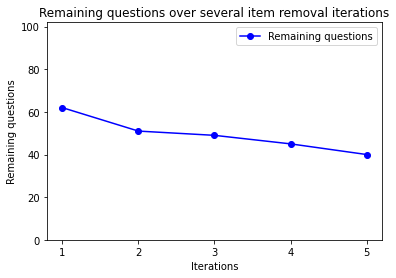

In [199]:
## Generation of the graph according to the data obtained.
labels = ['Remaining questions']
plt.title('Remaining questions over several item removal iterations')
plt.plot(iterations, total_question, marker= 'o', color = 'blue')
plt.ylabel("Remaining questions")
plt.xlabel("Iterations")
plt.ylim(0, 102)
plt.legend(labels)
plt.show()

Generation of the graph of the acurracy obtained in each iteration.

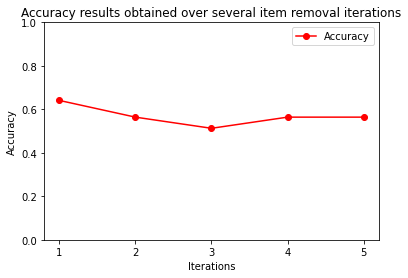

In [200]:
## Generation of the graph according to the data obtained.
labels=['Accuracy']
plt.title('Accuracy results obtained over several item removal iterations')
plt.plot(iterations, global_accuracy, marker= 'o', color = 'red')
plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.ylim(0, 1)
plt.legend(labels)
plt.show()

Generation of the graph of questions eliminated in each iteration.

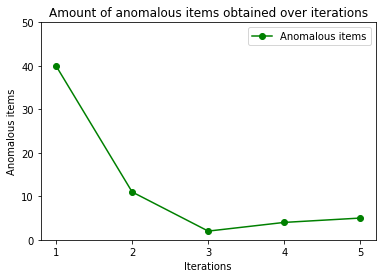

In [201]:
## Generation of the graph according to the data obtained.
labels=['Anomalous items']
plt.title('Amount of anomalous items obtained over iterations')
plt.plot(iterations, total_delete, marker= 'o', color = 'green')
plt.xlabel("Iterations")
plt.ylabel("Anomalous items")
plt.ylim(0, 50)
plt.legend(labels)
plt.show()

The graph is generated with the merger of the acurracy with the anomadic questions eliminated.

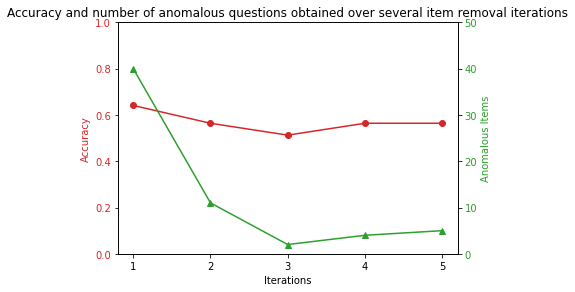

In [202]:
## Generation of the graph according to the data obtained.
fig, ax = plt.subplots()

ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy', color = 'tab:red')
ax.plot(iterations, global_accuracy, marker= 'o', color= 'tab:red')
ax.tick_params(axis='y', labelcolor= 'tab:red')

plt.ylim(0, 1)
ax = ax.twinx()  

ax.set_ylabel('Anomalous Items', color= 'tab:green')  
ax.plot(iterations, total_delete, marker= '^', color= 'tab:green')
ax.tick_params(axis='y', labelcolor= 'tab:green')

fig.tight_layout()
plt.title('Accuracy and number of anomalous questions obtained over several item removal iterations')
plt.xticks(range(0, 5, 1))
plt.ylim(0, 50)
plt.show()

The graph is generated with the fusion of the recall obtained in the improvement process.

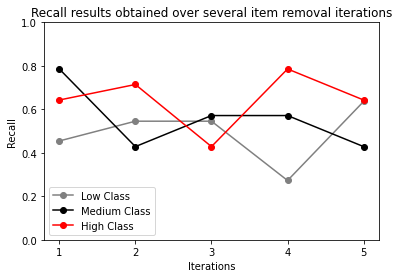

In [203]:
## Generation of the graph according to the data obtained.
labels=['Low Class','Medium Class', 'High Class']
plt.title('Recall results obtained over several item removal iterations')
plt.plot(iterations, recall_low, marker= 'o', color = 'gray')
plt.plot(iterations, recall_medium, marker= 'o', color = 'black')
plt.plot(iterations, recall_high, marker= 'o', color = 'red')
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.legend(labels)
plt.show()

The graph is generated with the fusion of the recall obtained in the improvement process.

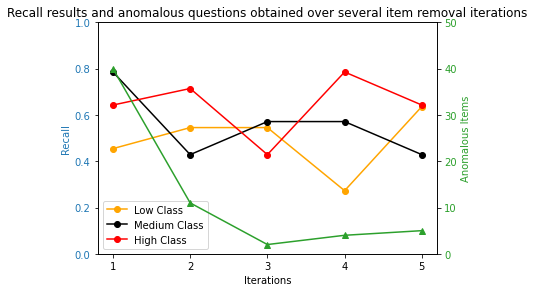

In [204]:
## Generation of the graph according to the data obtained.
fig, ax = plt.subplots()
label=['Low Class', 'Medium Class', 'High Class']

ax.set_xlabel('Iterations')
ax.set_ylabel('Recall', color= 'tab:blue')
ax.plot(iterations, recall_low, marker= 'o', color = 'orange')
ax.plot(iterations, recall_medium, marker= 'o', color = 'black')
ax.plot(iterations, recall_high, marker= 'o', color = 'red')
ax.tick_params(axis='y', labelcolor= 'tab:blue')

plt.ylim(0, 1)
plt.legend(label)
ax = ax.twinx()

ax.set_ylabel('Anomalous Items', color = 'tab:green')  
ax.plot(iterations, total_delete, marker= '^', color = 'tab:green')
ax.tick_params(axis='y', labelcolor = 'tab:green')

fig.tight_layout()
plt.title('Recall results and anomalous questions obtained over several item removal iterations')
plt.xticks(range(0, 5, 1))
plt.ylim(0, 50)
plt.show()